In [1]:
import numpy as np
import numba, os
from scipy.integrate import odeint
from scipy.linalg import solve_lyapunov, eigvals
from scipy.stats import linregress
import awesomeplot.core as ap
import baobap as bao
import cPickle as pickle
from scipy.linalg import norm

from tqdm import *

%matplotlib notebook

In [2]:
stepfunc = np.vectorize(lambda x, f: 0. if x < f else 1.)


In [3]:
def sub_dict_select(somedict, somekeys):
    return dict([ (k, somedict[k]) for k in somekeys if k in somedict])

In [4]:
canvas = ap.Plot(output="paper")
canvas.set_default_colours("discrete")

/data/condynet/Pauls_Playground/FiniteTimeBasinstability/scripts/simulation_data/results_ftbs_network.hdf

In [5]:
result_file = "simulation_data/results_ftbs_network.hdf"
batch_dir = os.path.join("simulation_data", "batch_data")

In [6]:
times = np.arange(0, 800, 0.1) # ATTENTION! manually copied over

_, args = bao.load_state_for_analysis(os.path.join(os.path.dirname(result_file), "analysis.p"))
sim_dir, alphas, fps, swingpar = args
n = swingpar.system_size

In [7]:
res = bao.load_all_fields_from_results(result_file)
print res.keys()

[u'run_conditions', u'conv', u'filt', u'max_abs_values', u'batch', u'fix_point', u'fin_abs_values', u'R', u'integration_step', u'return_time', u'system_size']


In [8]:
epsilons = res["filt"][0]
print epsilons
returns = res["return_time"].reshape(-1, res["return_time"].shape[-1])
fin = res["fin_abs_values"].reshape(-1, res["fin_abs_values"].shape[-1])
ic = res["run_conditions"].reshape(-1, res["run_conditions"].shape[-1])
N = res["system_size"][0]
if result_file == "simulation_data/results_ftbs_network.hdf":
    print "correct index error"
    returns -= 0.05

[  1.00000000e-06   1.00000000e-04   1.00000000e-03   1.00000000e-01
   1.00000000e+00   2.00000000e+00]
correct index error


In [9]:
nuller = dict()

for i in range(len(epsilons)):
    nuller[i] = list()
    t = returns[:, i]
    for idx, v in enumerate(t == 0):
        if v:
            point = ic[idx, :]
            point[:N] -= point[0]
            nuller[i].append((point, fin[idx, :]))

In [10]:
# should be empty
nuller

{0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

In [11]:
return_times = {}
for i, e in enumerate(epsilons):
    return_times[e] = returns[:, i]

In [31]:
data = {}
errs = {}

for e in tqdm(epsilons, total=len(epsilons)):
    ftbs = np.zeros_like(times)
    err = np.zeros_like(times)
    for j, t in enumerate(times):
        returned = (1 - stepfunc(return_times[e], t))
        ftbs[j] = np.mean(returned) 
        err[j] = np.sqrt(ftbs[j] * (1. - ftbs[j]) / np.sum(returned))
    data[r"$\epsilon$={:.0E}".format(e)] = ftbs
    errs[r"$\epsilon$={:.0E}".format(e)] = (ftbs - err, ftbs + err)
    

  0%|          | 0/6 [00:00<?, ?it/s]/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 6/6 [02:28<00:00, 23.52s/it]


In [ ]:
#lines[r"Scand. $\epsilon$={:.0E}".format(epsilons[0])] = data[r"$\epsilon$={:.0E}".format(epsilons[0])]

In [27]:
data.keys()[2:]

['$\\epsilon$=1E-06',
 '$\\epsilon$=1E-04',
 '$\\epsilon$=1E-03',
 '$\\epsilon$=1E-01']

In [28]:
basin_stability = np.mean(data['$\\epsilon$=1E-03'][-20:-2])
print basin_stability

0.43


<IPython.core.display.Javascript object>


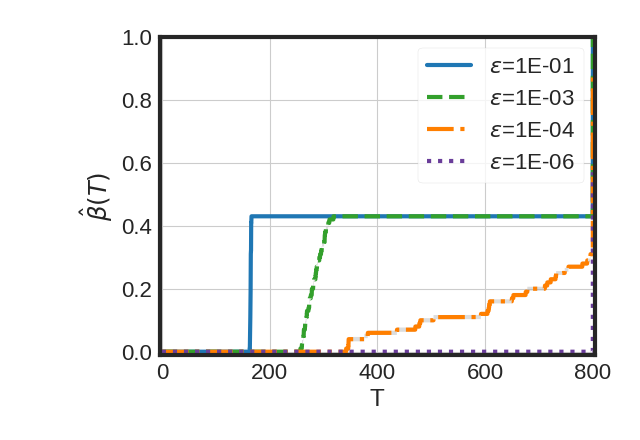

(-0.01, 1.0)

In [32]:
fig1 = canvas.add_lineplot(x=times, 
                           lines=sub_dict_select(data, data.keys()[2:]), 
                           shades=sub_dict_select(errs, data.keys()[2:]),
                           marker="", 
                           labels=["T", r"$\hat{\beta}(T)$"], 
                           grid=True)
#canvas.set_log(fig1, "x")
fig1.axes[0].set_ylim([-0.01, 1.])
#fig1.axes[0].set_xlim([0, 500])
#fig1.axes[0].legend()

In [100]:
# import infinite-busbar curves
lines = np.load("ftbs_curves.npy")[()]
times_2 = np.arange(0, 500, 0.01)

In [101]:
for k in lines.iterkeys():
    parts = k.split("$=")
    if len(parts) > 1:
        print parts
        new = r"$10^{{ {0} }}$".format(int(np.log10(float(parts[1]))))
        print new
        lines[new] = lines.pop(k)
    elif parts[0] == '$\\beta$':
        new = " " + "$\\hat\\beta$"
        print new
        lines[new] = lines.pop(k)
         

['$\\beta$']
['$\\epsilon', '1E-04']
$10^{ -4 }$
['$\\epsilon', '1E-02']
$10^{ -2 }$
['$\\epsilon', '1E-01']
$10^{ -1 }$


In [102]:
sorted(lines.keys())

[' $\\hat\\beta$', '$10^{ -1 }$', '$10^{ -2 }$', '$10^{ -4 }$']

In [103]:
canvas.update_params({'legend.fontsize': 14, 'legend.handlelength': 1.5})

<IPython.core.display.Javascript object>


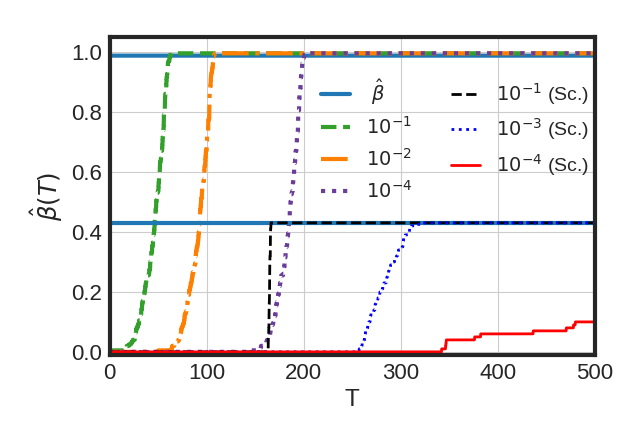

In [104]:
fig1 = canvas.add_lineplot(x=times_2, 
                           lines=lines, 
                           marker="", 
                           labels=["T", r"$\hat{\beta}(T)$"], 
                           grid=True,
                          legend=True)
#canvas.set_log(fig1, "x")


In [105]:
fig1.axes[0].axhline(y=data['$\\epsilon$=1E-03'][-2], xmin=0, xmax=500, linewidth=3)
fig1.axes[0].plot(times, data['$\\epsilon$=1E-01'], "k--", linewidth=2, label=r"{} (Sc.)".format('$10^{-1}$'))
fig1.axes[0].plot(times, data['$\\epsilon$=1E-03'], "b:", linewidth=2, label=r"{} (Sc.)".format('$10^{-3}$'))
fig1.axes[0].plot(times, data['$\\epsilon$=1E-04'], "r-", linewidth=2, label=r"{} (Sc.)".format('$10^{-4}$'))


In [106]:
fig1.axes[0].set_ylim([-0.01, 1.05])
fig1.axes[0].set_xlim([0, 500])

(0, 500)

In [109]:
#handles, labels = fig1.axes[0].get_legend_handles_labels()
#fig1.axes[0].legend(flip(handles, 2), flip(labels, 2), loc=9, ncol=2)
fig1.axes[0].legend(bbox_to_anchor=(0.4, 0.93), loc=2, ncol=2)
#plt.tight_layout()

In [110]:
canvas.save(fig=fig1, fnames="../figures/ftbs_curves_network")

# simulate some trajectories

In [13]:
np.random.seed(0)
# get the initial state of the RNG
st0 = np.random.get_state()
np.random.set_state(st0)

In [14]:
from libftbs import load_from_json, SwingGen, BatchSwing, SwingUniformGlobal, SwingObsNetwork
%reload_ext autoreload
%autoreload 2

In [15]:
swingpar = load_from_json("northern.json", shuffle_power=False, seed=st0, coupling_factor=1., alpha=0.)

Warning! run_on_master functions now always return None on none master nodes!Use an explicit broadcast to spread results
Warning! run_on_master functions now always return None on none master nodes!Use an explicit broadcast to spread results


In [16]:
freq_var = 1.
phase_var = np.pi / 3.

gen = SwingGen(swingpar)
brp = BatchSwing(number_of_batches=200, simulations_per_batch=100, time=400, step=0.05, filt=epsilons)
rcg = SwingUniformGlobal(brp, swingpar, max_rand=[phase_var, freq_var])
obs = SwingObsNetwork(brp, swingpar, batch_dir, freq_var=freq_var, phase_var=phase_var)

In [43]:
def iota_uniform_debug(point=[0, 0], fp=None):
    # px, py = np.abs(point)
    # a, b = R
    if fp is not None:
        point = np.array(point) - fp
    overlap = (2 * obs.R - np.abs(point)) * stepfunc(2 * obs.R - np.abs(point), 0) / (2. * obs.R)
    #print np.prod(overlap)
    if 0 in overlap:
        # if one overlap is 0, so is the product of all
        return 2.
    else:
        exponent = np.sum(np.log10(overlap))
        #print exponent
        return 2. - 2. * 10. ** exponent

In [36]:
iota_uniform_debug(nuller[0][0][0])

2.27633560925e-06
-5.64276370779


1.9999954473287815

In [42]:
ts = gen.create_ts(rc=nuller[0][0][0], times=times)

In [45]:
erg = np.zeros_like(times)
for i, point in enumerate(ts):
    erg[i] = iota_uniform_debug(point)

In [47]:
import matplotlib.pylab as plt

In [52]:
tsc = ts.copy()

In [66]:
nullphase = np.repeat(tsc[-1, 0], 236)

In [70]:
tsc[:, :236] -= nullphase

In [71]:
tsc[:, 0].shape

(8000,)

<IPython.core.display.Javascript object>


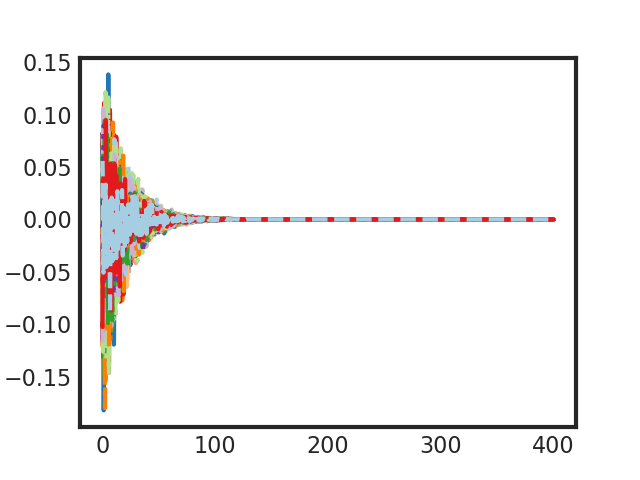

In [73]:
plt.figure()
plt.plot(times, tsc[:, :236]);

# independence times

from ftbs_curve.ipynb

basin_stability, err = 0.98, 0.0025074828669642249

In [ ]:
deltas = np.array([1e-5, 1e-4, 1e-1, 2e-1])

firstthe value for the small system

In [ ]:
epsilon_small = np.array([1e-4, 1e-2, 1e-1])

In [ ]:
data.keys()

In [ ]:
Tind = {}

for delta in tqdm(deltas):
    tc = np.zeros(len(data.keys()))
    for i, k in enumerate(data.keys()): 
        if k == "$\\beta$":
            continue
        else:
            print i, k
            ftbs = data[k]
            basin_stability = ftbs[-1]
            tc[i] = times[np.where(np.isclose(ftbs, basin_stability, atol=delta))[0][0]]
            #print delta, tc
    Tind[r"$\delta$={:.0E}".format(delta)] = tc

In [ ]:
Tind, epsilons

In [ ]:
fig5 = canvas.add_lineplot(x=epsilons,
                               lines=Tind,
                               labels=[r"$\epsilon$", r"$\hat{T}_{ind}(\epsilon, \delta)$"],
                               sortfunc=lambda x: float(x.split("-")[-1]),
                           grid=True
                               )